# Guided example + challenge

## First Attempt at Model

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV
# from sklearn.svm import LinearSVC
%matplotlib inline

raw_data = pd.read_csv('./data/epi_r.csv')
list(raw_data.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [2]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

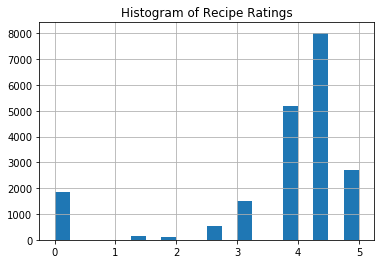

In [3]:
raw_data['rating'].hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [4]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [5]:
# from sklearn.svm import SVR
# svr = SVR()
# X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
# Y = raw_data.rating
# svr.fit(X,Y)

In [6]:
# plt.scatter(Y, svr.predict(X))

In [7]:
# svr.score(X, Y)

In [8]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(svr, X, Y, cv=5)

Now there are many things that we could do here.

- The overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

- We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

- We could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

## THAT IS YOUR CHALLENGE.

- Transform this regression problem into a binary classifier and clean up the feature set. 

- You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

- Also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so? (There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews. After all, people who eat chocolate might just be happier people.)

## Using SVM to Create a Binary Classifier

I will choose to exclude nutritional information to answer the original question – can a recipe's ingredients help predict its rating?

In [9]:
# Helper functions
def get_cols_with(df, food_name):
    return [col for col in df.columns if food_name in col]

def get_uniq_cols_with(df, all_food_names):
    answer = []
    for food_name in all_food_names:
        answer += get_cols_with(df, food_name)
    return list(set(answer))

def combine_cols(df, all_cols, new_name):
    df[new_name] = [0] * df.shape[0]

    for each_col in all_cols:
        df[new_name] += df[each_col]
    
    return df.drop(all_cols, 1)

In [10]:
# Make ratings into binary categories of low (<=4) and high (> 4)
df = raw_data.copy()
df['rating'] = ['low' if rating <= 4 else 'high' for rating in raw_data['rating']]
print('Distribution of high vs. low ratings:', df.rating.value_counts(normalize=True))

# Drop non-ingredient columns like nutritional facts, states, cities, countries, etc.
nutritional_facts = ['calories', 'protein', 'fat', 'sodium']
df = df.drop(nutritional_facts, axis=1)

states = ['alabama', 'alaska', 'arizona', 'california', 'colorado', 'connecticut', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri', 'nebraska', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'north carolina', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina', 'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington', 'washington, d.c.', 'west virginia', 'wisconsin']
cities = ['aspen', 'atlanta', 'beverly hills', 'boston', 'brooklyn', 'buffalo', 'cambridge', 'chicago', 'columbus', 'costa mesa', 'dallas', 'denver', 'healdsburg', 'hollywood', 'houston', 'kansas city', 'lancaster', 'las vegas', 'london', 'long beach', 'los angeles', 'louisville', 'miami', 'minneapolis', 'new orleans', 'pacific palisades', 'paris', 'pasadena', 'pittsburgh', 'portland', 'providence', 'san francisco', 'santa monica', 'seattle', 'st. louis', 'westwood', 'windsor', 'yonkers']
countries = ['australia', 'bulgaria', 'canada', 'chile', 'cuba', 'dominican republic', 'egypt', 'england', 'france', 'germany', 'guam', 'haiti', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'mexico', 'peru', 'philippines', 'spain', 'switzerland']
places = states + cities + countries
df = df.drop(places, axis=1)

holidays = get_uniq_cols_with(df, [' day', ' eve', 'new year', 'sgiving', 'christmas', 'week', 'passover']) + ['cinco de mayo', 'diwali', 'easter', 'fourth of july', 'halloween', 'hanukkah', 'kwanzaa', 'mardi gras', 'ramadan', 'rosh hashanah/yom kippur', 'sukkot']
events = get_uniq_cols_with(df, ['game', 'grill', 'bbq', 'barbecue', 'school', 'graduation', 'party', 'shower']) + ['30 days of groceries', 'anniversary', 'birthday', 'camping', 'entertaining', 'wedding', 'tailgating', 'family reunion', 'kentucky derby', 'oscars', 'parade', 'picnic', 'potluck', 'super bowl', 'oktoberfest']
seasons = get_uniq_cols_with(df, ['fall', 'spring', 'summer', 'winter'])
times = holidays + events + seasons
df = df.drop(times, axis=1)

names = ['anthony bourdain', 'dorie greenspan', 'emeril lagasse', 'harpercollins', 'house & garden', 'nancy silverton', 'suzanne goin']
df = df.drop(names, axis=1)

# Cooking / food
appliances = get_uniq_cols_with(df, ['cooker']) + ['blender', 'food processor', 'candy thermometer', 'coffee grinder', 'double boiler', 'juicer', 'microwave', 'mixer', 'mortar and pestle', 'pasta maker', 'smoker', 'wok']
techniques = get_uniq_cols_with(df, ['kitchen', 'freeze', 'cook', 'fry']) + ['bake', 'boil', 'braise', 'brine', 'broil', 'chill', 'deep-fry', 'marinate', 'poach', 'roast', 'rub', 'sauté', 'simmer', 'steam', 'stir-fry']
foods = get_uniq_cols_with(df, ['cake', 'condiment', 'dessert', 'drink', 'pie', 'salad', 'sandwich', 'soup', 'stew', ' meal', 'casserole']) + ['aperitif', 'appetizer', 'breakfast', 'brunch', 'buffet', 'condiment', 'digestif', 'dinner', 'dip', "hors d'oeuvre", 'leftovers', 'lunch', 'lasagna', 'muffin', 'omelet', 'pizza', 'side', 'smoothie', 'snack', 'taco', 'waffle']
specs = get_uniq_cols_with(df, ['friendly', ' free', '-free', 'high ', 'low ', 'no ', '-no', 'no-', 'healthy', 'quick', 'kosher']) + ['organic', 'gourmet', 'raw', 'sugar conscious', 'tested & improved']
diets = ['paleo', 'pescatarian', 'vegan', 'vegetarian']
drinks = ['margarita', 'martini', 'iced coffee', 'iced tea', 'egg nog']
cooking = appliances + techniques + foods + specs + diets + drinks
df = df.drop(cooking, axis=1)

phrases = get_uniq_cols_with(df, ['epi ', 'cookbook', 'recipe', 'gift']) + ['#wasteless', 'bon appétit', 'bon app��tit', 'weelicious']
categories = ['advance prep required']
non_ingredients = ['title']
misc = phrases + categories + non_ingredients
df = df.drop(misc, axis=1)

all_sums = df.drop('rating', axis=1).sum()
sums_df = pd.DataFrame(all_sums)
ranked_sums = sums_df.sort_values(0, ascending=False)
# top_50_ingredients = ranked_sums[:50].index.values
bottom_50_ingredients = ranked_sums[len(ranked_sums.index)-50:].index.values

# print('Top 50:', top_50_ingredients)
print('Bottom 50:', bottom_50_ingredients)

# top_answer = [0]*len(df.index)
bottom_answer = [0]*len(df.index)

# for ingred in top_50_ingredients:
#     top_answer = top_answer + df[ingred]
    
for ingred in bottom_50_ingredients:
    bottom_answer = bottom_answer + df[ingred]

# df['top 50 ingredients'] = top_answer
df['bottom 50 ingredients'] = bottom_answer
df.head()

Distribution of high vs. low ratings: high    0.535508
low     0.464492
Name: rating, dtype: float64
Bottom 50: ['marshmallow' 'eau de vie' 'grains' 'tart' 'lychee' 'meatball' 'skewer'
 'spritzer' 'rabbit' 'octopus' 'poblano' 'biscuit' 'pomegranate juice'
 'cobbler/crumble' 'yuca' 'house cocktail' 'marscarpone' 'salsa'
 'apple juice' 'midori' 'granola' 'lingonberry' 'cranberry sauce'
 'flat bread' 'rosé' 'sardine' 'grappa' 'hamburger' 'bran' 'stock'
 'soufflé/meringue' 'macaroni and cheese' 'brownie' 'chili' 'hummus'
 'orzo' 'frittata' 'custard' 'meatloaf' 'sorbet' 'sourdough'
 'cr��me de cacao' 'caviar' 'grand marnier' 'crêpe' 'fritter' 'marinade'
 'burrito' 'quiche' 'mezcal']


,rating,alcoholic,almond,amaretto,anchovy,anise,apple,apple juice,apricot,artichoke,...,whiskey,white wine,whole wheat,wild rice,wine,yogurt,yuca,zucchini,turkey,bottom 50 ingredients
0,low,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Identify if there is bias early on (e.g. skewness)
# Address, before building model

# Add num_ingredients
df['num_ingredients'] = df.sum(axis=1)

cols_without_rating = list(df.columns)
cols_without_rating.remove('rating')

skewed_cols = ['rating', 'bottom 50 ingredients', 'num_ingredients']

for col in cols_without_rating:
    high_count = df.groupby('rating').sum()[col]['high']
    low_count = df.groupby('rating').sum()[col]['low']
    total_count = high_count + low_count
    diff_count = abs(high_count - low_count)
    if diff_count / total_count >= 0.25 and total_count >= 90:
        print(col, '– High:', high_count, ', Low:', low_count, ', Total:', total_count, ', % Difference:', diff_count / total_count)
        skewed_cols.append(col)
        
print('\n\n# Skewed Columns:', len(skewed_cols))
print(skewed_cols)

alcoholic – High: 293.0 , Low: 542.0 , Total: 835.0 , % Difference: 0.29820359281437125
arugula – High: 177.0 , Low: 101.0 , Total: 278.0 , % Difference: 0.2733812949640288
bass – High: 58.0 , Low: 32.0 , Total: 90.0 , % Difference: 0.28888888888888886
bitters – High: 26.0 , Low: 101.0 , Total: 127.0 , % Difference: 0.5905511811023622
blackberry – High: 91.0 , Low: 53.0 , Total: 144.0 , % Difference: 0.2638888888888889
bourbon – High: 80.0 , Low: 45.0 , Total: 125.0 , % Difference: 0.28
broccoli – High: 40.0 , Low: 82.0 , Total: 122.0 , % Difference: 0.3442622950819672
cocktail – High: 141.0 , Low: 239.0 , Total: 380.0 , % Difference: 0.2578947368421053
cranberry – High: 243.0 , Low: 127.0 , Total: 370.0 , % Difference: 0.31351351351351353
dried fruit – High: 130.0 , Low: 76.0 , Total: 206.0 , % Difference: 0.2621359223300971
feta – High: 152.0 , Low: 77.0 , Total: 229.0 , % Difference: 0.32751091703056767
fig – High: 105.0 , Low: 49.0 , Total: 154.0 , % Difference: 0.36363636363636365

In [12]:
df = df[df['num_ingredients'] > 0]
df = df[skewed_cols]
df.head()

,rating,bottom 50 ingredients,num_ingredients,alcoholic,arugula,bass,bitters,blackberry,bourbon,broccoli,...,rum,sage,sausage,spirit,steak,stuffing/dressing,sweet potato/yam,tofu,veal,turkey
0,low,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,high,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,low,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,high,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,low,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# # PCA to get down to 30 features
# from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_val_score
# from sklearn.svm import SVC

# pca_num_components = [35, 30, 25]

# def get_pca_cross_val_score(num_components):
#     X = df.drop('rating', 1)
    
#     pca = PCA(n_components=num_components)
#     principal_components = pca.fit_transform(X)
    
#     svc = SVC()
#     Y = df['rating']
#     X = principal_components
    
#     print(num_components, cross_val_score(svc, X, Y, cv=5))

# for num_components in pca_num_components:
#     get_pca_cross_val_score(num_components)

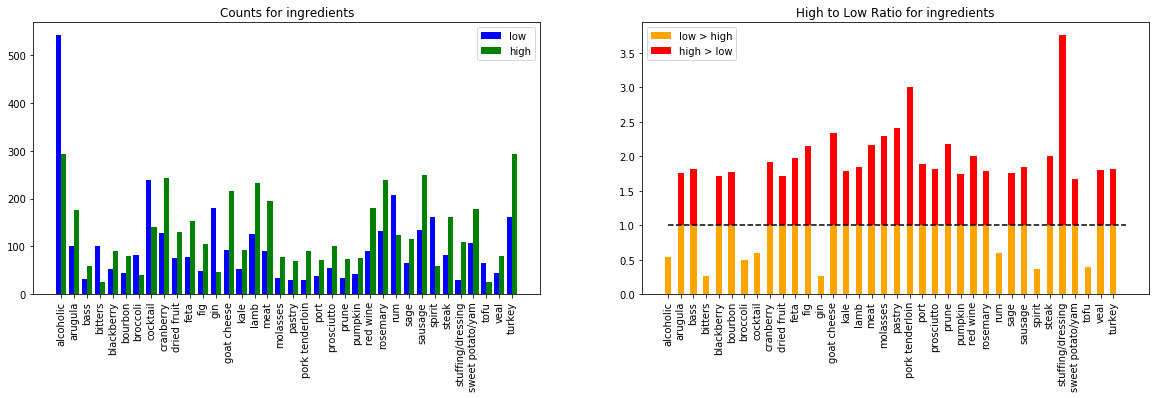

In [14]:
# Make bar graph for top skewed ingredients (38) – high count vs. low count
lows_vals = df[df['rating'] == 'low'].drop(['rating', 'bottom 50 ingredients', 'num_ingredients'], 1).sum()
highs_vals = df[df['rating'] == 'high'].drop(['rating', 'bottom 50 ingredients', 'num_ingredients'], 1).sum()

# Plot the counts of all ingredients for lows and highs
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 2, 1)
ax.bar(np.arange(len(list(lows_vals.index))) - 0.2, lows_vals, width=0.4, color='b', align='center', label="low")
ax.bar(np.arange(len(list(lows_vals.index))) + 0.2, highs_vals, width=0.4, color='g', align='center', label="high")
ax.set_xticks(range(len(list(lows_vals.index))))
ax.set_xticklabels(list(lows_vals.index), rotation=90)
ax.set_title('Counts for ingredients')
ax.legend()

# Make bar graph for top ingredients – high vs. low count ratio
ax = plt.subplot(1, 2, 2)

ratio_vals = highs_vals / lows_vals
threshold = 1
above_threshold = np.maximum(ratio_vals - threshold, 0)
below_threshold = np.minimum(ratio_vals, threshold)

ax.bar(np.arange(len(list(lows_vals.index))), ratio_vals, width=0.5, color='orange', label="low > high")
ax.bar(np.arange(len(list(lows_vals.index))), above_threshold, width=0.5, color='red', label="high > low", bottom=below_threshold)
       
ax.set_xticks(range(len(list(lows_vals.index))))
ax.set_xticklabels(list(lows_vals.index), rotation=90)
ax.set_title('High to Low Ratio for ingredients')

ax.plot([0, len(list(lows_vals.index))], [threshold, threshold], "k--") 
ax.legend()

plt.show()

In [17]:
# Specifies the kernel type to be used in the algorithm. 
# It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. Default 'rbf'

# GridSearch to find optimal hyperparameters (C, kernel)
def svc_param_selection(X, y, nfolds):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    Cs = [0.001, 0.01, 0.1, 1]
    param_grid = {'kernel': kernels, 'C': Cs}
    grid_search = GridSearchCV(SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

X = df.drop(['rating'], 1)
Y = df['rating']

best_params = svc_param_selection(X, Y, 5)
print('Best params:', best_params)
svc = SVC(**best_params)
svc.fit(X, Y)

Best params: {'C': 0.1, 'kernel': 'linear'}


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
# Score SVR model
print('SVC model score:', cross_val_score(svc, X, Y, cv=5))

SVC model score: [0.54698917 0.55583564 0.55381901 0.55129821 0.55255861]


In [ ]:
cv = CountVectorizer()
cv.fit(df)
all_features = cv.get_feature_names()

# Plot feature importance for all SVC model's features
# QUESTION: How to do this for non-linear kernel? https://stackoverflow.com/questions/45530461/top-10-features-svc-with-rbf-kernel
def plot_coefficients(model, feature_names, top_features=20):
    coef = model.coef_.ravel()
    print('Coefficients:', coef)
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

plot_coefficients(svc, all_features)

In [ ]:
pd.crosstab(svc.predict(X), Y, rownames=['Predicted'], colnames= ['Actual'], margins=True)

In [ ]:
df['num_ingredients'].hist(bins=20)
df.groupby('rating')['num_ingredients'].describe()

In [ ]:
new_df = df[df['num_ingredients'] <= 10]
new_df['num_ingredients'].hist(bins=20)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svc = SVC()

X = new_df.drop(['rating'], 1)
Y = new_df['rating']
svc.fit(X, Y)

# Score SVR model
print('SVC model score:', svc.score(X, Y))
cross_val_score(svc, X, Y, cv=5)